# Information-preserving compression of precipitation data

In [1]:
using NetCDF, BitInformation, PyPlot
using TranscodingStreams, CodecZstd, ColorSchemes
using PyCall, Dates
cartopy = pyimport("cartopy")
ccrs = pyimport("cartopy.crs");

In [2]:
ZstdCompressorL10 = ZstdCompressor(level=10)
TranscodingStreams.initialize(ZstdCompressorL10)

ZstdCompressorL22 = ZstdCompressor(level=22)
TranscodingStreams.initialize(ZstdCompressorL22)

In [3]:
ncfile_winter = NetCDF.open("radardata/metoffice-c-band-rain-radar_uk_20201231.nc")
ncfile_summer = NetCDF.open("radardata/metoffice-c-band-rain-radar_uk_20200617.nc")

rain_winter = ncfile_winter.vars["unknown"][:,:,:]
rain_summer = ncfile_summer.vars["unknown"][:,:,:]

lat = ncfile_winter.vars["latitude"][:]
lon = ncfile_winter.vars["longitude"][:]

date_origin = Dates.DateTime(1970,1,1)
time_winter = ncfile_winter.vars["time"]
time_summer = ncfile_summer.vars["time"]
datetimes_winter = [date_origin + Dates.Hour(ceil(i)) for i in time_winter]
datetimes_summer = [date_origin + Dates.Hour(ceil(i)) for i in time_summer]

rain_winter[rain_winter .< 0] .= 0     # filter negative values that occur due to remapping
rain_summer[rain_summer .< 0] .= 0;

In [4]:
bi_winter = bitinformation(rain_winter)
bi_summer = bitinformation(rain_summer);

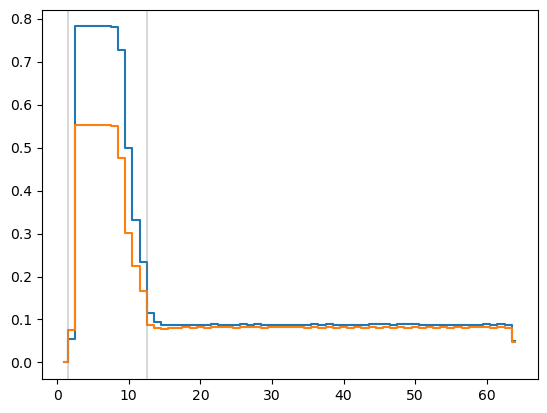

PyObject <matplotlib.lines.Line2D object at 0x7fae32a865b0>

In [5]:
plot(1:64,bi_winter,ds="steps-mid")
plot(1:64,bi_summer,ds="steps-mid")
axvline(1.5,color="grey",alpha=.3)
axvline(12.5,color="grey",alpha=.3)

In [6]:
keepbits_winter = 2
keepbits_summer = 2

2

In [7]:
rain_winter_r = round(rain_winter,keepbits_winter)
rain_summer_r = round(rain_summer,keepbits_summer);

In [8]:
rain_uint8 = copy(reinterpret(UInt8,vec(rain_winter_r)))
rain_winter_rc = transcode(ZstdCompressorL10,rain_uint8)

rain_uint8 = copy(reinterpret(UInt8,vec(rain_summer_r)))
rain_summer_rc = transcode(ZstdCompressorL10,rain_uint8);

In [9]:
compr_factor_winter = round(Int,sizeof(rain_winter)/sizeof(rain_winter_rc))
compr_factor_summer = round(Int,sizeof(rain_summer)/sizeof(rain_summer_rc))

46

In [10]:
function truncate_colormap(cmap::ColorMap, minval=0.0, maxval=1.0, n=100)
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("cmap_truncated",
        cmap(collect(range(minval,maxval,length=n))))
    return new_cmap
end

truncate_colormap (generic function with 4 methods)

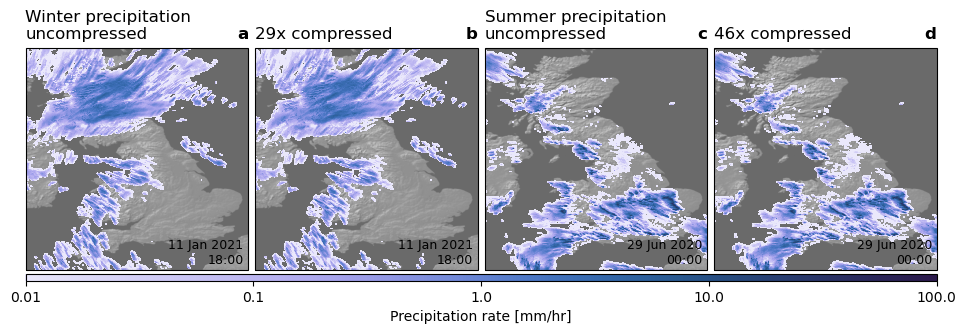

PyObject Text(0.98, 0.03, '29 Jun 2020\n00:00')

In [12]:
wstep = 9
sstep = 15
vmin = -2
vmax = round(log10(maximum(rain_summer)))
cmap = truncate_colormap(ColorMap(ColorSchemes.devon.colors).reversed(),0.1,1.0)
shading = "nearest"

fig = figure(figsize=(10,3.5))

ax1 = fig.add_subplot(1, 4, 1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 4, 2, projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(1, 4, 3, projection=ccrs.PlateCarree())
ax4 = fig.add_subplot(1, 4, 4, projection=ccrs.PlateCarree())
tight_layout(rect=[0.025,0.15,0.95,0.9],pad=0.5)

for ax in [ax1,ax2,ax3,ax4]
    ax.set_extent([-7.5, 2, 49.5, 59], crs=ccrs.PlateCarree())
    ax.background_img(name="ne_grey",resolution="high")
end

cax = fig.add_axes([ax1.get_position().x0,
                    ax1.get_position().y0-0.03,
                    ax4.get_position().x1-ax1.get_position().x0,
                    0.02])

q = ax1.pcolormesh(lon,lat,log10.(rain_winter[:,:,wstep]');vmin,vmax,cmap,shading)
ax2.pcolormesh(lon,lat,log10.(rain_winter_r[:,:,wstep]');vmin,vmax,cmap,shading)

ax3.pcolormesh(lon,lat,log10.(rain_summer[:,:,sstep]');vmin,vmax,cmap,shading)
ax4.pcolormesh(lon,lat,log10.(rain_summer_r[:,:,sstep]');vmin,vmax,cmap,shading)

cb = colorbar(q,cax=cax,orientation="horizontal")
tiks = [1e-2,1e-1,1e0,1e1,1e2]
cb.set_ticks(log10.(tiks))
cb.set_ticklabels(tiks)
cb.set_label("Precipitation rate [mm/hr]")

wintertime_str = Dates.format(datetimes_winter[wstep],"d u yyyy\nHH:MM")
summertime_str = Dates.format(datetimes_summer[sstep],"d u yyyy\nHH:MM")

ax1.set_title("Winter precipitation\nuncompressed",loc="left")
ax2.set_title("$(compr_factor_winter)x compressed",loc="left")

ax3.set_title("Summer precipitation\nuncompressed",loc="left")
ax4.set_title("$(compr_factor_summer)x compressed",loc="left")

for (iax,ax) in enumerate([ax1,ax2,ax3,ax4])
    ax.set_title(string(Char(96+iax)),loc="right",fontweight="bold")
    ax.grid(alpha=.3)
end

ax1.text(0.98,0.03,wintertime_str,transform=ax1.transAxes,fontsize=9,color="k",ha="right")
ax2.text(0.98,0.03,wintertime_str,transform=ax2.transAxes,fontsize=9,color="k",ha="right")
ax3.text(0.98,0.03,summertime_str,transform=ax3.transAxes,fontsize=9,color="k",ha="right")
ax4.text(0.98,0.03,summertime_str,transform=ax4.transAxes,fontsize=9,color="k",ha="right")

# savefig("precipitation_compression.png",dpi=200)